# Thermophysical Properties in Solids ::
This file serves to organize and show the solution method of all the equations of state used in the OpenFOAM model. The solid materials used are:

|         thermal conductivities organized              |
| material   | structure          | source filename     | Number | link to paper |
| -----------|--------------------|---------------------| ------ | ------------- |
| UZrC       | fuel               | k_UZrC.csv          |   1    | [k_UZrC](https://ntrs.nasa.gov/api/citations/20140010646/downloads/20140010646.pdf?attachment=true) |
| dense ZrC  |  assemblyCan       | k_zrC93PerRD.csv    |   2    | [k_denseZrC](https://www.mdpi.com/1996-1944/9/7/577) |
| porousZrC  | clad,insulator     | k_ZrC74PerRD.csv    |   3    | [k_porousZrC](https://www.mdpi.com/1996-1944/9/7/577) |
| Be         | moderator          | k_Be.csv            |   4    | [k_Be](http://poplab.stanford.edu/pdfs/Touloukian-v1ThermalConductivityMetallicElementsAlloys-tprc70.pdf) |
| H          | coolantChannels    | coolProp API        |   5    | [k_H](http://www.coolprop.org/) |


There is also another script called fittingScript.py. This script generates equations of state for the thermophysical properties of a few materials. Specificially, it finds the thermal conductivity equation of state for denseZrC,porousZrC, gasGapHydrogen, and Beryllium. At the top of the fittingScript there is a few comments showing citations for each of the thermophysical properties. Note that the citations in fittingScript for UZrC are no longer the citations being used, and instead I am using the citation linked above. The specific heat, viscosity, thermal conductivity, and density equations of state are all solved for in polynomialPLotter.ipynb. So far I have not created equations of state for specific heat in any of the solid components because specific heat and density make no difference in a steady state solution. 



In [7]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

The file below contains different kinds of functions to be fit

In [8]:
def polynomial4cf(t,c0,c1,c2,c3,c4,c5,c6): # t is temperature and c is the coefficiareents
    f = c0 + c1*t + c2*t**2 + c3*t**3 + c4*t**4 + c5*t**5
    return f
def polynomialLOG10(t,c0,c1): # t is temperature and c is the coefficiareents
    f = c0 * np.log10(c1 * t)
    return f
def polynomial8cf(t,c0,c1,c2,c3,c4,c5,c6,c7): # t is temperature and c is the coefficiareents
    f = c0 + c1*t + c2*t**2 + c3*t**3 + c4*t**4 + c5*t**5 + c6*t**6 + c7*t**7
    return f
def sutherland(t,As,Ts):
    f = (As * np.sqrt(t)) / (1 + Ts/t)
    return f
def printCoefs(c,name): # c is coefs
    print(name+'<8> (')
    print('\t'+"{0:.7E}".format(c[0]),"{0:.7E}".format(c[1]),"{0:.7E}".format(c[2]),"{0:.7E}".format(c[3]))
    print('\t'+"{0:.7E}".format(c[4]),"{0:.7E}".format(c[5]),"{0:.7E}".format(c[6]),"{0:.7E}".format(c[7]))
    print(');')

# |1|
The process below examines the data generated by the k_UZrC.csv file. It takes the datapoints in the file and creates a line of best fit. The link to the source of this data is: https://ntrs.nasa.gov/api/citations/20140010646/downloads/20140010646.pdf?attachment=true

kappaCoeffs<8> (
	1.9924905E+02 -5.6035148E-01 8.6141539E-04 -7.4210798E-07
	3.7158358E-10 -1.0662767E-13 1.6212679E-17 -1.0109105E-21
);
None


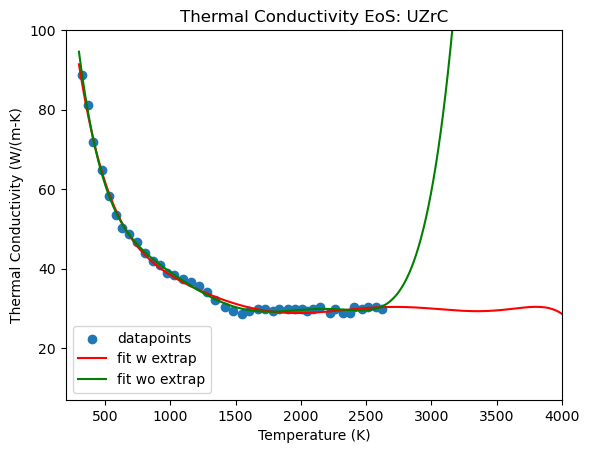

In [9]:
k_UZrC_data = np.genfromtxt('k_UZrC.csv',delimiter=',')
k_UZrC_data[:,1] = k_UZrC_data[:,1] * 100
new_extrapolate = interp1d(k_UZrC_data[:,0],k_UZrC_data[:,1],fill_value="extrapolate",kind='nearest-up')

kCoefs_UZrC, pcov = curve_fit(polynomial8cf,k_UZrC_data[:,1],k_UZrC_data[:,0])
kCoefsnew, pcov = curve_fit(polynomial8cf,k_UZrC_data[:,0],k_UZrC_data[:,1])
t_extended = np.linspace(300,4000,200)

k_to_fit = new_extrapolate(t_extended)
kCoefs_UZrC, pcov = curve_fit(polynomial8cf,t_extended,k_to_fit)


plt.figure(1)
plt.scatter(k_UZrC_data_new[:,0],k_UZrC_data_new[:,1],label='datapoints')
#plt.scatter(t_extended,new_extrapolate,label='extrap')
plt.plot(t_extended,polynomial8cf(t_extended,*kCoefs_UZrC),c='r',label='fit w extrap')
plt.plot(t_extended,polynomial8cf(t_extended,*kCoefsnew),c='g',label='fit wo extrap')
##plt.plot(t_extended,polynomial8cf(t_extended,*kCoefs_UZrC_extended2),c='r',label='fit2 poly')
plt.xlim(200,4000)
plt.ylim(7,100)
plt.title('Thermal Conductivity EoS: UZrC')
plt.xlabel('Temperature (K)')
plt.ylabel('Thermal Conductivity (W/(m-K)')
plt.legend()

print(printCoefs(kCoefs_UZrC,'kappaCoeffs'))

Now solving for thermal diffusivity to be used in laplacianFoam model

In [15]:
def getThermalDiffusivity(specificHeat,density,thermalConductivity):
    return thermalConductivity/(specificHeat*density)

thermalConductivity3000 = polynomial8cf(3000,*kCoefs_UZrC)  # grabbing thermal conduct @ 3000 K

# Cp = 500 J/(kg-K) taken from a paper
# rho = 5458 kg/m^3 taken from Cristian's baseline.mater
ThermalDiffusivity3000 = getThermalDiffusivity(500,5458,thermalConductivity3000)
print('DT = {:0.4e} m^2/s '.format(ThermalDiffusivity3000))

DT = 1.0973e-05 m^2/s 


# |2| 